# Stock Forecasting (Demo) 
- This code demonstrates the process of pre-training an RNN model with stock data and forecasting stock prices
- The code is divided into 3 parts:
    - Pre-training the RNN model with one stock
    - Continuing training the RNN model with a second stock
    - Forecasting the final stock


In [7]:
import datetime
import numpy as np
import pandas as pd
import torch
import stockcrawler
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error

In [8]:
def date_list(n):
    ds = []
    y = str(datetime.datetime.now().year)
    m = str(datetime.datetime.now().month)
    d = str(datetime.datetime.now().day)
    dates = pd.date_range(start=y + "-" + m + "-" + d, periods=n, freq="D")
    for date in dates:
        ds.append(datetime.datetime.strptime(str(date), "%Y-%m-%d %M:%H:%S"))
    return ds



- This function returns a list of dates starting from today, with n days in the future 
- Param n: number of days to forecast
- Returns: list of dates

In [5]:
def save_to_xlsx(code):
    strlist=stockcrawler.get_url(code)
    stockcrawler.get_data(strlist,code)

- This function saves stock data to an excel file
- Param code: stock code

In [6]:
def read_from_excel(file, n, train_end, columns):  
    """  
    从Excel读取股票数据  
    :param file: 文件名  
    :param n: 时间序列长度  
    :param train_end: 划分训练集和测试集索引  
    :param columns: 需要的列  
    :return: df_train, df_test, df, dates 训练集，测试集，所有数据，时间索引  
    """  
    df = pd.read_excel(file)  # 使用 read_excel 方法读取数据  

    df = df.sort_values("date")  # 按照日期排序  

    df_trade_date = df["date"]  # 获取日期列作为时间索引  

    df = df[columns]  # 选择需要的列  

    # 替换 0 值  
    # df[columns] = replace_zeros_with_neighbors(df[columns].values)  
    
    # 丢弃包含0值的行  
    #df = df[(df != 0).all(axis=1)]  # 只保留所有列均不为0的行  

    dates = []  
    for date in df_trade_date.tolist():  
        dates.append(datetime.datetime.strptime(str(date), "%Y-%m-%d"))  

    if train_end == 0:  
        train_end = len(df)  

    df_train, df_test = df[:train_end], df[train_end - n:]  

    return df_train, df_test, df, dates  

- This function reads stock data from an excel file
- Param file: file name
- Param n: length of time series
- Param train_end: index to split training and testing data
- Returns: df_train, df_test, df, dates

In [10]:
def series_data(df, n):
    """
    将数据组装成时间序列
    :param df: DataFrame对像
    :param n: 时间序列长度
    :return: data, label 数据和标签的numpy数组对象
    """
    data = []
    label = []
    for i in range(len(df) - n):
        d = df[i:n + i].values
        l = df[n + i:n + i + 1][["open", "high", "low", "close"]].values

        data.append(d)
        label.append(l)

    return np.array(data), np.array(label)


- This function assembles data into time series
- Param df: DataFrame object
- Param n: length of time series
- Returns: data, label

In [9]:
def standard_scaler(df):
    """
    数据标准化处理
    :param df: DataFrame对象
    :return: df,mean_map,std_map 标准化后的DataFrame对象，每列的均值，每列的标准差
    """
    df = df.copy()
    mean_map = {}
    std_map = {}
    for idx in df:
        mean = df[idx].mean()
        std = df[idx].std()
        for i in df.index:
            df.loc[i, idx] -= mean
            df.loc[i, idx] /= std
        mean_map[idx] = mean
        std_map[idx] = std
    return df, mean_map, std_map

- This function standardizes data
- Param df: DataFrame object
- Returns: df, mean_map, std_map

In [11]:
def get_row_count(file):
    df = pd.read_excel(file)
    row_count = len(df)-1
    print("数据集数量为:",row_count,"条")
    train_portion=float(0.7)
    while train_portion>1 or train_portion<0:
        print("输入错误，请重新输入")
        train_portion=float(input("选择测试集和训练集的比例划分,输入测试集所占比例(0-1):"))

    return row_count*train_portion

- This function returns the number of rows in a dataset
- Param file: file name
- Returns: row_count

In [12]:

def replace_zeros_with_neighbors(arr):  
    """  
    替换数组中的0值，使用上下邻居的平均值  
    :param arr: 输入数组  
    :return: 替换后的数组  
    """  
    arr = arr.copy()  # 复制数组以避免修改原始数据  

    for i in range(arr.shape[0]):  # 遍历每一行  
        for idx in range(arr.shape[1]):  # 遍历每一列  
            if arr[i, idx] == 0:  
                valid_neighbors = []  

                # 向上查找  
                for up in range(i + 1, arr.shape[0]):  
                    if arr[up, idx] != 0:  
                        valid_neighbors.append(arr[up, idx])  
                        break  

                # 向下查找  
                for down in range(i - 1, -1, -1):  
                    if arr[down, idx] != 0:  
                        valid_neighbors.append(arr[down, idx])  
                        break  

                # 如果找到了有效邻居，则替换  
                if valid_neighbors:  
                    arr[i, idx] = np.mean(valid_neighbors)  
                else:  
                    arr[i, idx] = np.nan  # 如果没有有效值，设为NaN  

    # 处理 NaN  
    for idx in range(arr.shape[1]):  
        # 计算非零值的平均  
        non_zero_mean = np.nanmean(arr[:, idx][arr[:, idx] != 0])  
        arr[:, idx] = np.where(np.isnan(arr[:, idx]), non_zero_mean, arr[:, idx])  # 替换 NaN  

    return arr  

In [ ]:
def find_first_local_minimum(prices):  
    for i in range(1, len(prices) - 1):  
        if prices[i - 1] > prices[i] < prices[i + 1]:  
            return i  # 返回局部最低点的索引  
    return 0  # 如果没有局部最低，则返回0  


In [ ]:
def calculate_profit_from_start_date(predicted_open_prices, initial_investment, start_day,datelist):  
    shares = 0  # 当前持有的股票数量  
    cash = initial_investment  # 可用资金  
    last_open_price = predicted_open_prices[start_day]  # 当前日开盘价  
    
    for day in range(start_day + 1, len(predicted_open_prices)):  
        current_open_price = predicted_open_prices[day]  
        if cash==0:
            print(f"{datelist[day].date()},持股")
        # 买入操作  
        if current_open_price > last_open_price and cash > 0:  
            shares = cash / last_open_price  # 以前一日开盘价买入  
            cash = 0  # 资金清空  
            print(f"{datelist[day].date()}: 买入 {shares} 股，价格 {last_open_price}")
        # 卖出操作  
        elif shares > 0 and current_open_price < last_open_price:  
            cash = shares * current_open_price  # 卖出所有股票，资金回笼  
            shares = 0  # 清空持有股数  
            print(f"日 {datelist[day].date()}: 卖出 {shares} 股，价格 {current_open_price}")
        last_open_price = current_open_price  

    # 在预测周期结束时，如果持有股票，则以最后一天价格卖出  
    if shares > 0:  
        cash = shares * last_open_price  
        print(f"预测结束：最后卖出持有 {shares} 股，价格 {last_open_price}")
    total_profit_percentage = ((cash - initial_investment) / initial_investment) * 100  
    return total_profit_percentage  

- This function predicts the profit in percentage from the predict start to the end of the prediction period, it checks for the 1st local minimum point, assumes the user buys at the 1st local minimum point and sells at the next local maximum point. Keeps doing that until the very last local maximum.
- Param predicted_open_prices: predicted open prices
- Param initial_investment: initial investment
- Param start_day: start day of prediction
- Returns: total_profit_percentage


In [47]:
def show(code, train_end, n, columns, p):
    """
    画图显示，并预测下一个交易日的开盘价，最高价，收盘价，最低价
    :param code: 股票代码
    :param train_end: 训练集测试集分割下标
    :param n: 时间序列
    :return:
    """
    rnn = torch.load(code+".pkl")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    rnn.to(device)
    df_train, df_test, df, dates = read_from_excel(code + "_history.xlsx", n, train_end, columns)
    if train_end == 0:
        train_end = len(df)
    elif train_end < 0:
        train_end = len(df) + train_end
    # 进行验证并画图显示
    train = []
    test = []
    predict = []
    predict_dates = date_list(p)

    df_all_normal, mean, std = standard_scaler(df)
    means = np.array([mean["open"], mean["high"], mean["low"], mean["close"]])
    stds = np.array([std["open"], std["high"], std["low"], std["close"]])
    ts_all_normal = torch.Tensor(df_all_normal.values)
    predict_normal = df_all_normal[-n:].values.tolist()

    for i in range(n, len(df)):
        x = ts_all_normal[i - n:i].to(device)
        x = torch.unsqueeze(x, dim=0)
        y = rnn(x).to(device)
        y = torch.squeeze(y).detach().cpu().numpy()[-1, :]

        yy = y * stds + means
        if i < train_end:
            train.append(yy)
        else:
            test.append(yy)

    for i in range(p):
        ts_predict_normal = torch.Tensor(predict_normal)
        x = ts_predict_normal[i:i + n].to(device)
        x = torch.unsqueeze(x, dim=0)
        y = rnn(x).to(device)
        y = torch.squeeze(y).detach().cpu().numpy()[-1, :]
        yy = y * stds + means
        predict.append(yy)
        predict_normal.append(y.tolist())

    for i in range(len(predict)):
        print("预测第{}天的开盘价:{:.2f} 最高价:{:.2f} 最低价:{:.2f} 收盘价:{:.2f}".format(i + 1, predict[i][0], predict[i][1],
                                                                           predict[i][2], predict[i][3]))

    train = np.array(train)
    test = np.array(test)
    predict = np.array(predict)
    
    # 计算绝对误差和相对误差
    train_true = df_train[["open", "high", "low", "close"]].values[n:]
    test_true = df_test[["open", "high", "low", "close"]].values[n:]

   
        

    train_mae = mean_absolute_error(train_true, train)
    test_mae = mean_absolute_error(test_true, test)
    
    
    # train_mask = np.all(train_true != 0, axis=1)  # 确保整行没有0  
    # test_mask = np.all(test_true != 0, axis=1)     # 确保整行没有0  
    # 
    # train_relative_error = np.mean(np.abs((train[train_mask] - train_true[train_mask]) / train_true[train_mask]))  
    # test_relative_error = np.mean(np.abs((test[test_mask] - test_true[test_mask]) / test_true[test_mask]))  


    
    train_relative_error = np.mean(np.abs((train_true - train) / train_true))  
    test_relative_error = np.mean(np.abs((test_true - test) / test_true))  

    # 计算相对误差，忽略train_true中的0值  
    # train_relative_error = np.mean(np.abs((train_true[train_true != 0] - train[train_true != 0]) / train_true[train_true != 0]))  
    # test_relative_error = np.mean(np.abs((test_true[test_true != 0] - test[test_true != 0]) / test_true[test_true != 0]))  
    
    # 将 train_true 中的 0 替换为 1e-10  
    # train_true = np.where(train_true == 0, 1e-10, train_true)  
    # test_true = np.where(test_true == 0, 1e-10, test_true)  
    # train_relative_error = np.mean(np.abs((train_true - train) / train_true))  
    # test_relative_error = np.mean(np.abs((test_true - test) / test_true))  
    
    # profit = calculate_profit(predict[0,:],21 )  
    # 找到第一个局部最低点  
    first_local_min_index = find_first_local_minimum(predict[:, 0])  
    
    # 从找到的局部最低点开始计算利润  
    profit = calculate_profit_from_start_date(predict[:,0], 100, first_local_min_index, predict_dates)  
    # best_start_day, max_profit = find_best_strategy(predict[0][:], 100)  
    
    print(f"从第 {first_local_min_index} 天开始的收益为: {profit:.2f}%")  
    print(f'Train MAE: {train_mae}')
    print(f'Test MAE: {test_mae}')
    print(f'Train Relative Error: {train_relative_error}')
    print(f'Test Relative Error: {test_relative_error}')
    plt.rcParams["font.sans-serif"] = ["KaiTi"]
    plt.rcParams["axes.unicode_minus"] = False

    plt.figure(1,figsize=(15, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    plt.subplot(221)
    plt.plot(dates[n:train_end], train[:, 0], color="#ff0000", label="训练集", linewidth="1")
    if train_end != len(df):
        plt.plot(dates[train_end:], test[:, 0], color="#0000ff", label="测试集", linewidth="1")
    plt.plot(dates, df["open"], color="#00ff00", label="真实数据", linewidth="1",linestyle='dotted')
    plt.plot(predict_dates, predict[:, 0], color="#000000", label="预测数据", linewidth="1")
    plt.xlabel("时间")
    plt.ylabel("价格")
    plt.title("开盘价")
    plt.legend()

    plt.subplot(222)
    plt.plot(dates[n:train_end], train[:, 1], color="#ff0000", label="训练集", linewidth="1")
    if train_end != len(df):
        plt.plot(dates[train_end:], test[:, 1], color="#0000ff", label="测试集", linewidth="1")
    plt.plot(dates, df["high"], color="#00ff00", label="真实数据", linewidth="1",linestyle='dotted')
    plt.plot(predict_dates, predict[:, 1], color="#000000", label="预测数据", linewidth="1",linestyle='-.')
    plt.xlabel("时间")
    plt.ylabel("价格")
    plt.title("最高价")
    subdates=dates+predict_dates
    plt.xlim([subdates[-1-p], predict_dates[-1]])  # 设置 x 轴显示范围
    # plt.ylim([df["open"].min(), df["open"].max()])  # 设置 y 轴显示范围
    plt.legend()
    
    plt.subplot(223)
    plt.plot(dates[n:train_end], train[:, 2], color="#ff0000", label="训练集", linewidth="1")
    if train_end != len(df):
        plt.plot(dates[train_end:], test[:, 2], color="#0000ff", label="测试集", linewidth="1")
    plt.plot(dates, df["low"], color="#00ff00", label="真实数据", linewidth="1",linestyle='dotted')
    plt.plot(predict_dates, predict[:, 2], color="#000000", label="预测数据", linewidth="1")
    plt.xlabel("时间")
    plt.ylabel("价格")
    plt.title("最低价")
    plt.legend()

    plt.subplot(224)
    plt.plot(dates[n:train_end], train[:, 3], color="#ff0000", label="训练集", linewidth="1")
    if train_end != len(df):
        plt.plot(dates[train_end:], test[:, 3], color="#0000ff", label="测试集", linewidth="1")
    plt.plot(dates, df["close"], color="#00ff00", label="真实数据", linewidth="1",linestyle='dotted')
    plt.plot(predict_dates, predict[:, 3], color="#000000", label="预测数据", linewidth="1")
    plt.xlabel("时间")
    plt.ylabel("价格")
    plt.title("收盘价")
    plt.legend()
    plt.show()


- This function displays the forecasted stock prices
- Param code: stock code that is being forecasted
- Param train_end: index to split training and testing data
- Param n: length of time series
- Param columns: feature columns to be forecasted
- Param p: number of days to forecast


In [14]:
class RNN(torch.nn.Module):
    def __init__(self, input_size):
        """
        循环神经网络实现，采用LSTM
        :param input_size: 输入的特征维度
        """
        super(RNN, self).__init__()
        self.rnn = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=128,
            num_layers=2,
            batch_first=True
        )
        self.out = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 4)
        )

    def forward(self, x):
        """
        前向传播
        :param x: 输入数据
        :return:
        """
        r_out, (h_n, h_c) = self.rnn(x, None)
        out = self.out(r_out)
        return out


- This class defines the RNN model
- Param input_size: input feature dimension
- forward: forward propagation
- Returns: out

In [15]:
class TrainSet(Dataset):
    def __init__(self, data, label):
        self.data, self.label = data.float(), label.float()

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

- This class defines the training dataset
- Param data: input data
- Param label: output label
- Returns: data, label

In [16]:
# 超参数
# 学习率
LR = 0.0001
# EPOCH大小
EPOCH = 50

if __name__ == "__main__":
    # 首次训练
    print("首次训练")
    first_stock_code = '300446'
    save_to_xlsx(first_stock_code)
    n = int(30)
    print("选择训练集长度")
    train_end=int(get_row_count(first_stock_code + "_history.xlsx"))
    #p = int(input("请输入预测天数:"))

    # 爬取和读取数据

    columns = ["open", "high", "low", "close"]
    df_train_first, df_test_first, df_first, dates_first = read_from_excel(first_stock_code + "_history.xlsx", n, train_end,
                                                                           columns)

    # 标准化处理
    df_train_normal_first, mean_first, std_first = standard_scaler(df_train_first)

    # 构建训练数据
    np_train_normal_first, np_label_normal_first = series_data(df_train_normal_first, n)

    # 转为 Tensor
    ts_train_normal_first = torch.Tensor(np_train_normal_first)
    ts_label_normal_first = torch.Tensor(np_label_normal_first)
    train_set_first = TrainSet(ts_train_normal_first, ts_label_normal_first)
    train_loader_first = DataLoader(train_set_first, batch_size=10, shuffle=False)

    # 初始化 RNN 模型
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    rnn = RNN(df_train_first.shape[1])
    rnn.to(device)

    # 训练模型
    optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, last_epoch=-1)
    loss_func = torch.nn.MSELoss()

    for step in range(EPOCH):
        for tx, ty in train_loader_first:
            tx, ty = tx.to(device), ty.to(device)
            output = rnn(tx)
            loss = loss_func(torch.squeeze(output[:, -1, :]), torch.squeeze(ty))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        print(f"第 {step + 1} 个 Epoch 的损失: {loss.item()}")

    # 保存模型
    torch.save(rnn,first_stock_code + "_model.pkl")
    print("第一支股票模型训练完成并保存。")

首次训练
正在获取数据...
选择训练集长度
数据集数量为: 2176 条
第 1 个 Epoch 的损失: 0.017324570566415787
第 2 个 Epoch 的损失: 0.0010106894187629223
第 3 个 Epoch 的损失: 0.0068830279633402824
第 4 个 Epoch 的损失: 0.014840882271528244
第 5 个 Epoch 的损失: 0.013600967824459076
第 6 个 Epoch 的损失: 0.009154299274086952
第 7 个 Epoch 的损失: 0.006057596765458584
第 8 个 Epoch 的损失: 0.004315306432545185
第 9 个 Epoch 的损失: 0.003313907189294696
第 10 个 Epoch 的损失: 0.00266135367564857
第 11 个 Epoch 的损失: 0.00036712578730657697
第 12 个 Epoch 的损失: 0.00033973631798289716
第 13 个 Epoch 的损失: 0.00034028664231300354
第 14 个 Epoch 的损失: 0.000348389963619411
第 15 个 Epoch 的损失: 0.0003603096993174404
第 16 个 Epoch 的损失: 0.00037390884244814515
第 17 个 Epoch 的损失: 0.0003889068902935833
第 18 个 Epoch 的损失: 0.00040459365118294954
第 19 个 Epoch 的损失: 0.00041976856300607324
第 20 个 Epoch 的损失: 0.00043483683839440346
第 21 个 Epoch 的损失: 0.0004137709620408714
第 22 个 Epoch 的损失: 0.0003807465545833111
第 23 个 Epoch 的损失: 0.00035912261228077114
第 24 个 Epoch 的损失: 0.00034415186382830143
第 25 个 Epoch

- This code pre-trains the RNN model with the 1st stock the user 
- The user is prompted to enter the stock code, sequence length, and training/test set split
- The model is trained and saved

In [17]:
# 二次训练
second_stock_code = '300078'
save_to_xlsx(second_stock_code)
n = int(30)
print("选择训练集长度")
train_end=int(get_row_count(second_stock_code + "_history.xlsx"))
#p = int(input("请输入预测天数:"))
# 爬取和读取数据

df_train_second, df_test_second, df_second, dates_second = read_from_excel(second_stock_code + "_history.xlsx", n,
                                                                           train_end, columns)

# 标准化处理
df_train_normal_second, mean_second, std_second = standard_scaler(df_train_second)

# 构建训练数据
np_train_normal_second, np_label_normal_second = series_data(df_train_normal_second, n)

# 转为 Tensor
ts_train_normal_second = torch.Tensor(np_train_normal_second)
ts_label_normal_second = torch.Tensor(np_label_normal_second)
train_set_second = TrainSet(ts_train_normal_second, ts_label_normal_second)
train_loader_second = DataLoader(train_set_second, batch_size=10, shuffle=False)

# 加载已训练模型参数
rnn=torch.load(first_stock_code + "_model.pkl")
# 重新初始化学习率
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
# 继续训练模型
for step in range(EPOCH):
    for tx, ty in train_loader_second:
        tx, ty = tx.to(device), ty.to(device)
        output = rnn(tx)
        loss = loss_func(torch.squeeze(output[:, -1, :]), torch.squeeze(ty))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"二次训练 - 第 {step + 1} 个 Epoch 的损失: {loss.item()}")

# 保存增量训练后的模型
torch.save(rnn,second_stock_code+"_model.pkl")
print("第二支股票增量训练完成并保存。")

正在获取数据...
选择训练集长度
数据集数量为: 3252 条
二次训练 - 第 1 个 Epoch 的损失: 0.013111557811498642
二次训练 - 第 2 个 Epoch 的损失: 0.01260371319949627
二次训练 - 第 3 个 Epoch 的损失: 0.011173475533723831
二次训练 - 第 4 个 Epoch 的损失: 0.009803764522075653
二次训练 - 第 5 个 Epoch 的损失: 0.008570868521928787
二次训练 - 第 6 个 Epoch 的损失: 0.007515858858823776
二次训练 - 第 7 个 Epoch 的损失: 0.006606485228985548
二次训练 - 第 8 个 Epoch 的损失: 0.0058207884430885315
二次训练 - 第 9 个 Epoch 的损失: 0.005136065185070038
二次训练 - 第 10 个 Epoch 的损失: 0.004536739084869623
二次训练 - 第 11 个 Epoch 的损失: 0.003997902385890484
二次训练 - 第 12 个 Epoch 的损失: 0.0035197348333895206
二次训练 - 第 13 个 Epoch 的损失: 0.0030667658429592848
二次训练 - 第 14 个 Epoch 的损失: 0.0027163391932845116
二次训练 - 第 15 个 Epoch 的损失: 0.00239002937451005
二次训练 - 第 16 个 Epoch 的损失: 0.0024373913183808327
二次训练 - 第 17 个 Epoch 的损失: 0.0021166701335459948
二次训练 - 第 18 个 Epoch 的损失: 0.002708176150918007
二次训练 - 第 19 个 Epoch 的损失: 0.002411817666143179
二次训练 - 第 20 个 Epoch 的损失: 0.0024020506534725428
二次训练 - 第 21 个 Epoch 的损失: 0.002150720451027155
二次训练 

- This code continues training the previous RNN model with the 2nd stock
- The learning rate of the model is re-initialized
- The user is prompted to enter the stock code, sequence length, and training/test set split for the 2nd time
- The model is trained and saved again

预测
正在获取数据...
数据集数量为: 4377 条
三次训练-第 1 个 Epoch 的损失: 0.0010982210515066981
三次训练-第 2 个 Epoch 的损失: 0.0017189150676131248
三次训练-第 3 个 Epoch 的损失: 0.001514313742518425
三次训练-第 4 个 Epoch 的损失: 0.0014319568872451782
三次训练-第 5 个 Epoch 的损失: 0.0014478536322712898
三次训练-第 6 个 Epoch 的损失: 0.001524252351373434
三次训练-第 7 个 Epoch 的损失: 0.0015823652502149343
三次训练-第 8 个 Epoch 的损失: 0.0016538731288164854
三次训练-第 9 个 Epoch 的损失: 0.0016978619387373328
三次训练-第 10 个 Epoch 的损失: 0.0017438315553590655
三次训练-第 11 个 Epoch 的损失: 0.0017856117337942123
三次训练-第 12 个 Epoch 的损失: 0.0018254416063427925
三次训练-第 13 个 Epoch 的损失: 0.0018716998165473342
三次训练-第 14 个 Epoch 的损失: 0.0019252749625593424
三次训练-第 15 个 Epoch 的损失: 0.001960606314241886
三次训练-第 16 个 Epoch 的损失: 0.0020182172302156687
三次训练-第 17 个 Epoch 的损失: 0.002076832577586174
三次训练-第 18 个 Epoch 的损失: 0.0020977798849344254
三次训练-第 19 个 Epoch 的损失: 0.0020345463417470455
三次训练-第 20 个 Epoch 的损失: 0.0019255585502833128
三次训练-第 21 个 Epoch 的损失: 0.0017790643032640219
三次训练-第 22 个 Epoch 的损失: 0.001634191256016

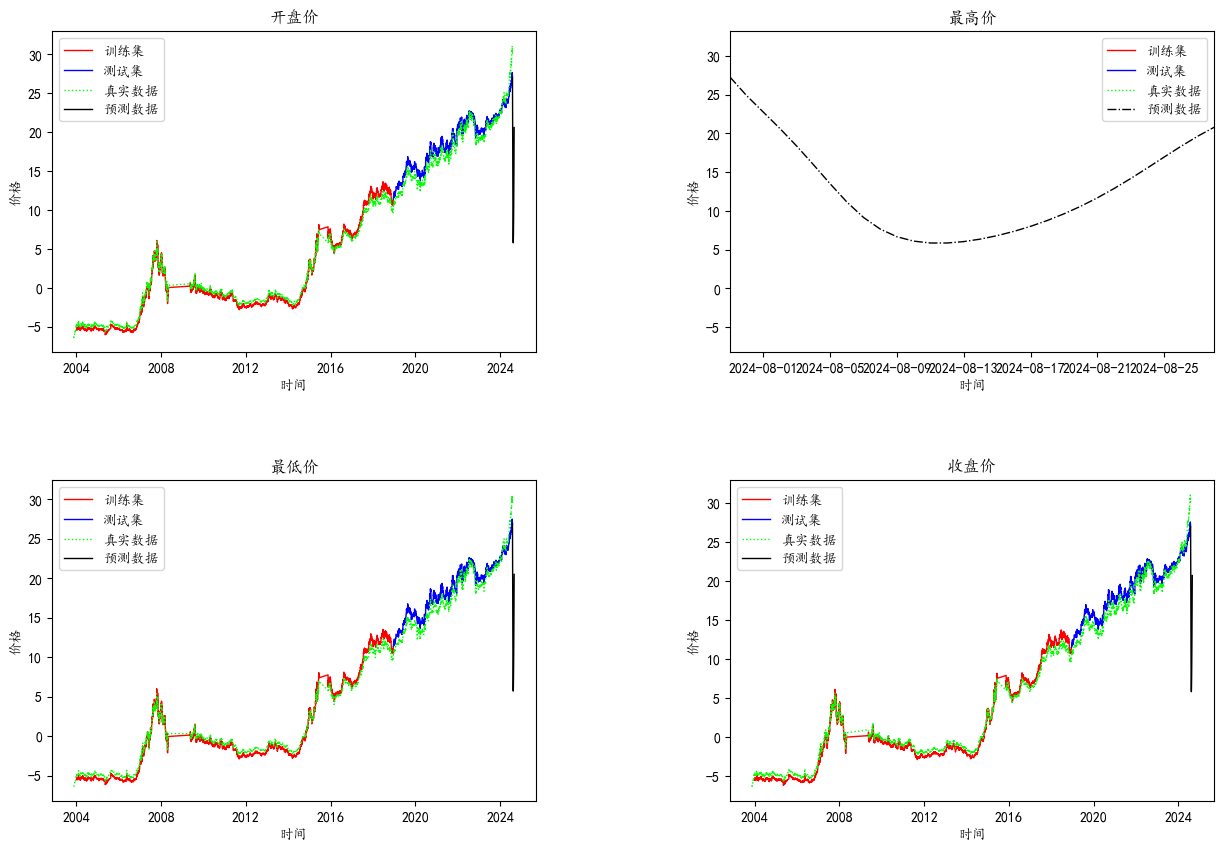

In [48]:
 # 预测
print("预测")
code='600900'
save_to_xlsx(code)
n = int(30)

train_end = int(get_row_count(code + "_history.xlsx"))
p = int(30)
# 爬取和读取数据

#df_predict, _, _, _ = read_from_excel(code + "_history.xlsx", n, 0, columns)
df_train, df_test, df, dates = read_from_excel(code + "_history.xlsx", n, train_end, columns)


# 将数据标准化或归一化处理
df_train_normal, mean, std = standard_scaler(df_train)
# 将数据组装成时间序列
np_train_normal, np_label_normal = series_data(df_train_normal, n)
# 将数据转成Tensor对象，并保存到DataLoader里
ts_train_normal = torch.Tensor(np_train_normal)
ts_label_normal = torch.Tensor(np_label_normal)
train_set = TrainSet(ts_train_normal, ts_label_normal)
train_loader = DataLoader(train_set, batch_size=10, shuffle=False)

# 加载已训练模型参数
rnn = torch.load(second_stock_code + "_model.pkl")
# 重新初始化学习率
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)

# 开始训练
for step in range(EPOCH):
    for tx, ty in train_loader:
        # 将数据加载到GPU中
        tx = tx.to(device)
        ty = ty.to(device)
        output = rnn(tx)
        # 计算损失
        loss = loss_func(torch.squeeze(output[:, -1, :]), torch.squeeze(ty))
        # 梯度清零
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 更新权重
        optimizer.step()
    scheduler.step()
    # 打印每个epoch的损失
    print(f"三次训练-第 {step + 1} 个 Epoch 的损失: {loss.item()}")

torch.save(rnn, code + ".pkl")


show(code, train_end, n, columns, p)


- 
- This code forecasts final predictions of ['open','high','low','close'] for the 3rd stock
- The user is prompted to enter the stock code, sequence length, and training/test set split and ***number of days to forecast***
- The model is trained and saved again
- The forecasted stock data is then displayed

In [19]:
# 定义买入卖出策略函数  
def calculate_profit(predicted_open_prices, initial_investment):  
    # 初始设定  
    shares = 0  # 当前持有的股票数量  
    cash = initial_investment  # 可用资金  
    bought_price = 0  # 记录买入的价格  
    total_profit_percentage = 0  # 总盈利百分比  
    buy_signal = False  # 持股状态  
    last_open_price = predicted_open_prices[0]  # 第一日开盘价  

    for day in range(1, len(predicted_open_prices)):  
        current_open_price = predicted_open_prices[day]  
        
        # 计算与前一天的百分比变化  
        price_change_percentage = ((current_open_price - last_open_price) / last_open_price) * 100  
        
        # 如果当前价格比前一天上涨，并且没有持仓，则买入  
        if price_change_percentage > 0 and not buy_signal:  
            shares = cash / last_open_price  # 以前一日开盘价买入  
            bought_price = last_open_price  # 记录买入价格  
            cash = 0  # 资金清空  
            buy_signal = True  # 设置为持股状态  
            print(f"日 {day}: 买入 {shares} 股，价格 {bought_price}")  
        
        # 如果当前价格下跌，卖出  
        elif buy_signal and price_change_percentage < 0:  
            cash = shares * current_open_price  # 卖出所有股票，资金回笼  
            total_profit_percentage += ((current_open_price - bought_price) / bought_price) * 100  # 记录盈利  
            print(f"日 {day}: 卖出 {shares} 股，价格 {current_open_price}，盈利: {((current_open_price - bought_price) / bought_price) * 100:.2f}%")  
            shares = 0  # 清空持有股数  
            buy_signal = False  # 重置持股状态  
        
        # 更新上一个开盘价  
        last_open_price = current_open_price  

    # 在预测周期结束时，如果持有股票，则以最后一天价格卖出  
    if buy_signal and shares > 0:  
        cash = shares * last_open_price  
        total_profit_percentage += ((last_open_price - bought_price) / bought_price) * 100  
        print(f"预测结束：最后卖出持有 {shares} 股，价格 {last_open_price}，盈利: {((last_open_price - bought_price) / bought_price) * 100:.2f}%")  
    
    # 总盈利百分比  
    total_profit_percentage = ((cash - initial_investment) / initial_investment) * 100  
    print(f"总盈利百分比: {total_profit_percentage:.2f}%")  
    
    return total_profit_percentage  